# Evaluating networks using webcam frames

This script loads camera frames and uses the Regression and Classification networks to determine the presence, location and class of a number within the captured image.

In [1]:
# Be careful with the OpenCV installation. Video codecs are required to load camera.
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
print cv2.__version__
import tensorflow as tf

2.4.9


## Loading Regression and Classification models

In [2]:
# Loading Regression model

num_labels = 5   # Presence, top, left, buttom, right

patch_size = 3
depth1 = 32
depth2 = 48
depth3 = 64
depth4 = 80
flat_size = 960
num_hidden1 = 2048 #3072

graph = tf.Graph()
with graph.as_default():
    # Input data.
    tf_image_input = tf.placeholder(tf.float32, shape=(1, 48, 64, 3))
    
    # Variables.
    layer1_1weights = tf.get_variable("W11", shape=[patch_size, patch_size, 3, depth1],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_1biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B11')
    layer1_2weights = tf.get_variable("W12", shape=[patch_size, patch_size, depth1, depth1],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer1_2biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B12')
    
    layer2_1weights = tf.get_variable("W21", shape=[patch_size, patch_size, depth1, depth2],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_1biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B21')
    layer2_2weights = tf.get_variable("W22", shape=[patch_size, patch_size, depth2, depth2],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer2_2biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B22')
    
    layer3_1weights = tf.get_variable("W31", shape=[patch_size, patch_size, depth2, depth3],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_1biases = tf.Variable(tf.constant(1.0, shape=[depth3]), name='B31')  
    layer3_2weights = tf.get_variable("W32", shape=[patch_size, patch_size, depth3, depth3],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer3_2biases = tf.Variable(tf.constant(1.0, shape=[depth3]), name='B32')
    
    layer4_1weights = tf.get_variable("W41", shape=[patch_size, patch_size, depth3, depth4],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer4_1biases = tf.Variable(tf.constant(1.0, shape=[depth4]), name='B41')    
    layer4_2weights = tf.get_variable("W42", shape=[patch_size, patch_size, depth4, depth4],\
                                      initializer=tf.contrib.layers.xavier_initializer_conv2d())
    layer4_2biases = tf.Variable(tf.constant(1.0, shape=[depth4]), name='B42')    
        
    full_weights = tf.get_variable("FW1", shape=[flat_size, num_hidden1],\
                                    initializer=tf.truncated_normal_initializer(stddev=0.05, dtype=tf.float32 ))
    full_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden1]), name='FB1')

    # Classifier output: wether there is a number or not
    presence_w = tf.get_variable("WO1", shape=[num_hidden1, 2],\
                           initializer=tf.contrib.layers.xavier_initializer())
    presence_b = tf.Variable(tf.constant(1.0, shape=[2]), name='BO1')
    
    # BBox information
    top_w = tf.get_variable("WO2", shape=[num_hidden1, 1],\
                           initializer=tf.contrib.layers.xavier_initializer())
    top_b = tf.Variable(tf.constant(1.0, shape=[1]), name='BO2')
    left_w = tf.get_variable("WO3", shape=[num_hidden1, 1],\
                           initializer=tf.contrib.layers.xavier_initializer())
    left_b = tf.Variable(tf.constant(1.0, shape=[1]), name='BO3')   
    buttom_w = tf.get_variable("WO4", shape=[num_hidden1, 1],\
                           initializer=tf.contrib.layers.xavier_initializer())
    buttom_b = tf.Variable(tf.constant(1.0, shape=[1]), name='BO4')   
    right_w = tf.get_variable("WO5", shape=[num_hidden1, 1],\
                           initializer=tf.contrib.layers.xavier_initializer())
    right_b = tf.Variable(tf.constant(1.0, shape=[1]), name='BO5')   
  
    
    # Model.
    def model(data, keep_prob):
        conv = tf.nn.conv2d(data, layer1_1weights, [1,1,1,1], 'SAME', name='C11')
        hidden = tf.nn.relu(conv + layer1_1biases)
        conv = tf.nn.conv2d(hidden, layer1_2weights, [1,1,1,1], 'SAME', name='C12')
        hidden = tf.nn.relu(conv + layer1_2biases)
        
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P1')
        
        conv = tf.nn.conv2d(sub, layer2_1weights, [1,1,1,1], padding='SAME', name='C21')
        hidden = tf.nn.relu(conv + layer2_1biases)
        conv = tf.nn.conv2d(hidden, layer2_2weights, [1,1,1,1], padding='SAME', name='C22')
        hidden = tf.nn.relu(conv + layer2_2biases)
        
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P2')
        
        conv = tf.nn.conv2d(sub, layer3_1weights, [1,1,1,1], padding='SAME', name='C31')
        hidden = tf.nn.relu(conv + layer3_1biases)
        conv = tf.nn.conv2d(hidden, layer3_2weights, [1,1,1,1], padding='SAME', name='C32')
        hidden = tf.nn.relu(conv + layer3_2biases)
                
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P3')
            
        conv = tf.nn.conv2d(sub, layer4_1weights, [1,1,1,1], padding='SAME', name='C41')
        hidden = tf.nn.relu(conv + layer4_1biases)
        conv = tf.nn.conv2d(hidden, layer4_2weights, [1,1,1,1], padding='SAME', name='C42')
        hidden = tf.nn.relu(conv + layer4_2biases)
        
        lrn = tf.nn.local_response_normalization(hidden)
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P4')
        shape = int(np.prod(sub.get_shape()[1:]))
        #print(shape)
        flat_layer = tf.reshape(sub,[-1,shape])
        hidden = tf.nn.relu(tf.matmul(flat_layer, full_weights) + full_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)
        
        out0 = tf.matmul(hidden, presence_w) + presence_b
        out1 = tf.matmul(hidden, top_w) + top_b
        out2 = tf.matmul(hidden, left_w) + left_b
        out3 = tf.matmul(hidden, buttom_w) + buttom_b
        out4 = tf.matmul(hidden, right_w) + right_b
        return [out0, tf.concat(1, [out1,out2,out3,out4])]
    
    bbox_regression = tf.concat(1, [tf.nn.softmax(model(tf_image_input, 1.0)[0]), model(tf_image_input, 1.0)[1]])                                 
    saver = tf.train.Saver()      
    savename = "Models/RegressionModel.ckpt"
    sess = tf.InteractiveSession()
    saver.restore(sess, savename)
    print('Model restored.')

Model restored.


In [3]:
# Loading Classification model

num_labels = 11 # 0-9, + blank 
num_digits = 5

patch_size = 3
depth1 = 32
depth2 = 48
depth3 = 64
depth4 = 96
flat_size = 1536
fc_size = 3136

graph_classification = tf.Graph()
with graph_classification.as_default():
    # Input data.
    tf_input_crop_color = tf.placeholder(tf.float32, shape=(1, 54, 54, 3))
    tf_input_crop_gray = tf.image.rgb_to_grayscale(tf_input_crop_color)
    
    # Variables.
    conv1_1weights = tf.get_variable("W1_1", shape=[patch_size, patch_size, 1, depth1],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv1_1biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1_1')
    conv1_2weights = tf.get_variable("W1_2", shape=[patch_size, patch_size, depth1, depth1],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv1_2biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1_2')
    
    conv2_1weights = tf.get_variable("W2_1", shape=[patch_size, patch_size, depth1, depth2],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv2_1biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2_1')
    conv2_2weights = tf.get_variable("W2_2", shape=[patch_size, patch_size, depth2, depth2],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv2_2biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B2_2')
    
    conv3_1weights = tf.get_variable("W3_1", shape=[patch_size, patch_size, depth2, depth3],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv3_1biases = tf.Variable(tf.constant(1.0, shape=[depth3]), name='B3_1')
    conv3_2weights = tf.get_variable("W3_2", shape=[patch_size, patch_size, depth3, depth3],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv3_2biases = tf.Variable(tf.constant(1.0, shape=[depth3]), name='B3_2')
    
    conv4_1weights = tf.get_variable("W4_1", shape=[patch_size, patch_size, depth3, depth4],\
                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv4_1biases = tf.Variable(tf.constant(1.0, shape=[depth4]), name='B4_1')
    conv4_2weights = tf.get_variable("W4_2", shape=[patch_size, patch_size, depth4, depth4],\
                                     initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv4_2biases = tf.Variable(tf.constant(1.0, shape=[depth4]), name='B4_2')

    fc_weights = tf.get_variable("FW1", shape=[flat_size, fc_size],\
                                    initializer=tf.truncated_normal_initializer(stddev=0.05, dtype=tf.float32 ))
    fc_biases = tf.Variable(tf.constant(1.0, shape=[fc_size]), name='FB1')
    
    s1_w = tf.get_variable("WS1", shape=[fc_size, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s1_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS1')
    s2_w = tf.get_variable("WS2", shape=[fc_size, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s2_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS2')
    s3_w = tf.get_variable("WS3", shape=[fc_size, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s3_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS3')
    s4_w = tf.get_variable("WS4", shape=[fc_size, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s4_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS4')
    s5_w = tf.get_variable("WS5", shape=[fc_size, num_labels],\
                           initializer=tf.contrib.layers.xavier_initializer())
    s5_b = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='BS5')
        
    # Model.
    def model_number(data, keep_prob):
        # First Conv stage
        conv = tf.nn.conv2d(data, conv1_1weights, [1,1,1,1], 'SAME', name='C1_1')
        hidden = tf.nn.relu(conv + conv1_1biases)  
        conv = tf.nn.conv2d(hidden, conv1_2weights, [1,1,1,1], 'SAME', name='C1_2')
        hidden = tf.nn.relu(conv + conv1_2biases)
        lrn = tf.nn.local_response_normalization(hidden)
        # Pooling
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P1')
        
        # Second Conv stage
        conv = tf.nn.conv2d(sub, conv2_1weights, [1,1,1,1], padding='SAME', name='C2_1')
        hidden = tf.nn.relu(conv + conv2_1biases)
        conv = tf.nn.conv2d(hidden, conv2_2weights, [1,1,1,1], 'SAME', name='C2_2')
        hidden = tf.nn.relu(conv + conv2_2biases)
        
        lrn = tf.nn.local_response_normalization(hidden)
        # Pooling
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P2')
        
        conv = tf.nn.conv2d(sub, conv3_1weights, [1,1,1,1], padding='SAME', name='C3_1')
        hidden = tf.nn.relu(conv + conv3_1biases)
        conv = tf.nn.conv2d(hidden, conv3_2weights, [1,1,1,1], padding='SAME', name='C3_2')
        hidden = tf.nn.relu(conv + conv3_2biases)
        
        lrn = tf.nn.local_response_normalization(hidden)
        # Pooling
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P3')
        
        conv = tf.nn.conv2d(sub, conv4_1weights, [1,1,1,1], padding='SAME', name='C4_1')
        hidden = tf.nn.relu(conv + conv4_1biases)
        conv = tf.nn.conv2d(hidden, conv4_2weights, [1,1,1,1], padding='SAME', name='C4_2')
        hidden = tf.nn.relu(conv + conv4_2biases)
        
        lrn = tf.nn.local_response_normalization(hidden)
        # Pooling
        sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='P4')
        
        shape = int(np.prod(sub.get_shape()[1:]))

        flat_layer = tf.reshape(sub,[-1,shape])
        hidden = tf.nn.relu(tf.matmul(flat_layer, fc_weights) + fc_biases)
        hidden = tf.nn.dropout(hidden, keep_prob)

        logits1 = tf.matmul(hidden, s1_w) + s1_b
        logits2 = tf.matmul(hidden, s2_w) + s2_b
        logits3 = tf.matmul(hidden, s3_w) + s3_b
        logits4 = tf.matmul(hidden, s4_w) + s4_b
        logits5 = tf.matmul(hidden, s5_w) + s5_b
        return [logits1, logits2, logits3, logits4, logits5]
    
    number_classification = tf.pack([tf.nn.softmax(model_number(tf_input_crop_gray, 1.0)[0]),\
                                tf.nn.softmax(model_number(tf_input_crop_gray, 1.0)[1]),\
                                tf.nn.softmax(model_number(tf_input_crop_gray, 1.0)[2]),\
                                tf.nn.softmax(model_number(tf_input_crop_gray, 1.0)[3]),\
                                tf.nn.softmax(model_number(tf_input_crop_gray, 1.0)[4])])
                                 
    saver = tf.train.Saver()  
    
    savename = "Models/ClassificationModel.ckpt"
    sess_classification = tf.Session()
    saver.restore(sess_classification, savename)
    print('Model restored.')

Model restored.


## Define the functions calling the models

In [4]:
# This function is called to get the bounding box surrounding the number (if present)
def get_bbox(img):
    img = np.expand_dims(img, axis=0)
    prediction = sess.run(bbox_regression, feed_dict = {tf_image_input: img})

    # The Box can not be larger than the image (or contain negative values)
    prediction[0,2:] = np.maximum(prediction[0,2:], 0)
    prediction[0,2] = np.minimum(prediction[0,2], 48)
    prediction[0,4] = np.minimum(prediction[0,4], 48)
    prediction[0,3] = np.minimum(prediction[0,3], 64)
    prediction[0,5] = np.minimum(prediction[0,5], 64)
    return prediction

In [5]:
# This function calls the classification model
def get_number(img):
    img = np.expand_dims(img, axis=0)
    Net_Output = sess_classification.run(number_classification, feed_dict = {tf_input_crop_color: img})
    Net_Output = np.transpose(np.argmax(Net_Output,axis=2))[0]
    Number_Output = ''
    for digit in Net_Output:
        if digit==10:
            break
        else:
            Number_Output += str(digit)
    return Number_Output

## Testing the networks with a single frame

(480, 640, 3)


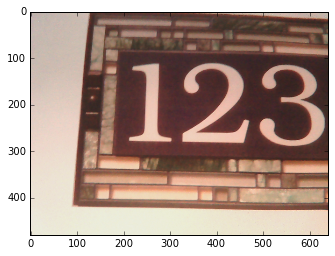

In [19]:
# capture a frame from the camera
camera = cv2.VideoCapture(-1)
ret, frame = camera.read()
plt.imshow(frame)
camera.release()
print frame.shape

# Resize the image to fit the Regression network input size
resized = cv2.resize(frame, (64, 48), interpolation = cv2.INTER_AREA)
resized = np.reshape(resized, (48, 64, 3))

# Subtract mean
resized = resized - np.average(resized)

223


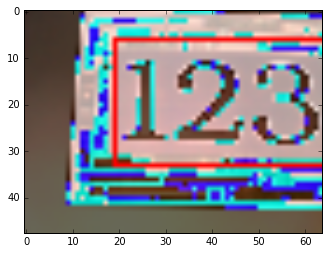

In [20]:
# Get bounding box
prediction = get_bbox(resized)
clone = Image.fromarray(np.uint8(resized[:,:,:]))
# If a number is detected
if prediction[0][1]>=0.7:

    # Crop the predicted bounding box
    im2 = clone.crop((prediction[0][3], prediction[0][2], prediction[0][5], prediction[0][4])).resize([54,54], Image.ANTIALIAS)
    
    # Draw the bounding box on top of the original image
    draw = ImageDraw.Draw(clone)
    draw.rectangle([prediction[0][3], prediction[0][2], prediction[0][5], prediction[0][4]], \
                   fill=None, outline=(255,0,0))
    
    # Subtract mean
    im2 = im2 - np.average(im2)
    
    # Call classification model and print result
    print(get_number(im2))

    plt.imshow(clone)

## Test the network on video sequences

Press Q to quit

In [28]:
Prop_y = 480.0 / 48.0
Prop_x = 640.0 / 64.0
camera = cv2.VideoCapture(-1)
while(True):
    # Capture frame-by-frame
    ret, frame = camera.read()

    # Our operations on the frame come here
    clone = frame.copy()
    
    # Resize the image to Regression model input size
    resized = cv2.resize(frame, (64, 48), interpolation = cv2.INTER_AREA)
    resized = np.reshape(resized, (48, 64, 3))

    # Subtract mean
    resized = resized - np.average(resized)
    
    # Execute Regression model
    prediction = get_bbox(resized)[0]

    # If a number is detected
    if prediction[1]>=0.7:
        # Crop and scale bounding box to Classification model input size
        cropped = resized[prediction[2]:prediction[4], prediction[3]:prediction[5]]
        cropped = cv2.resize(cropped, (54, 54), interpolation = cv2.INTER_AREA)
        # Subtract mean
        cropped = cropped - np.average(cropped)
        
        # Get transcription
        number = get_number(cropped)
        
        # Get Bbox
        top_left = (int(prediction[3]*Prop_x),int(prediction[2]*Prop_y))
        buttom_right = (int(prediction[5]*Prop_x),int(prediction[4]*Prop_y))
        
        # Plot bounding box
        cv2.rectangle(clone, top_left, buttom_right, (0, 0, 255), 3)
    
        # Place prediction on screen
        cv2.putText(clone,number, (20,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255),2)
    
    # Display the resulting frame
    cv2.imshow('frame',clone)
    
    # We exit pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
camera.release()
cv2.destroyAllWindows()

/home/camigord/anaconda2/envs/Neptuno/lib/python2.7/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
